___

This notebook shows the different data analysis, feature engineering, and model selection steps took to develop the end to end machine learning pipeline that would be deployed in a docker container.

---

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import xgboost as xgb

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from util import *

In [2]:
data= pd.read_csv( '../data_root/raw/wine_dataset.csv', index_col= 0)
data.drop_duplicates( inplace= True)
data.dropna( axis= 0, how= 'all', inplace= True)
data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Fragrances suggest hay, crushed tomato vine an...",Kirchleiten,90,30.0,Northeastern Italy,Alto Adige,NaN,Kerin O’Keefe,@kerinokeefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon,Tiefenbrunner
1,France,"Packed with fruit and crisp acidity, this is a...",NaN,87,22.0,Loire Valley,Sancerre,NaN,Roger Voss,@vossroger,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé,Bernard Reverdy et Fils
2,Italy,"This easy, ruby-red wine displays fresh berry ...",NaN,86,NaN,Tuscany,Chianti Classico,NaN,NaN,NaN,Dievole 2009 Chianti Classico,Sangiovese,Dievole
3,US,Pretty in violet and rose petals this is a low...,Horseshoe Bend Vineyard,92,50.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Davis Family 2012 Horseshoe Bend Vineyard Pino...,Pinot Noir,Davis Family
4,US,This golden wine confounds in a mix of wet sto...,Dutton Ranch,93,38.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Dutton-Goldfield 2013 Dutton Ranch Chardonnay ...,Chardonnay,Dutton-Goldfield


In [3]:
pd.DataFrame( [data.nunique(), data.isnull().sum()], index= ['unique','nan'])

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
unique,37,9942,5381,21,188,248,724,17,18,14,9930,333,5460
nan,6,0,2813,0,676,6,1653,6112,1983,2353,0,0,0


## Exploratory analysis on the data

---

In [4]:
data.describe()

,points,price
count,9942.000000,9266.000000
mean,88.459264,35.458990
std,3.034672,40.979322
min,80.000000,5.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,1300.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9942 entries, 0 to 9999
Data columns (total 13 columns):
country                  9936 non-null object
description              9942 non-null object
designation              7129 non-null object
points                   9942 non-null int64
price                    9266 non-null float64
province                 9936 non-null object
region_1                 8289 non-null object
region_2                 3830 non-null object
taster_name              7959 non-null object
taster_twitter_handle    7589 non-null object
title                    9942 non-null object
variety                  9942 non-null object
winery                   9942 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 1.1+ MB


The ratings, or labels, range from a bottom of 80 to the highest of 100. The labels have a standard distribution of 3.03 around a mean of 88.46. The distribution is more or less Gaussian and looks representative of wine ratings across the world with possible exception of the mean rating which is 88.46, supposedly out of a perfect rating of 100.

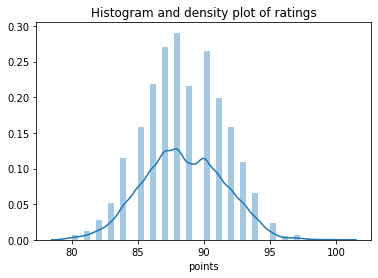

In [6]:
sns.distplot( data.points)
plt.title('Histogram and density plot of ratings')
plt.show()

The wine prices consist of a couple of outliers and missing values. For example, the dataset includes a 1300, presumably in US dollars, Bordeaux wine which consequently got a rating of 96. Since the mean price is 35.46, such expensive wines are handled using a log scale. As could be inferred from the figure below, the majority of the prices are under 100, where 75% of the prices are under 50.

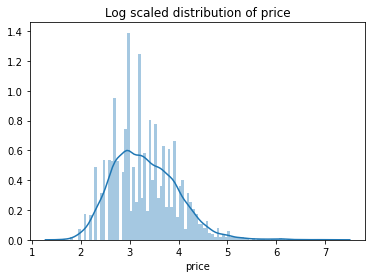

In [7]:
sns.distplot( np.log( data.price[ data.price.notnull()]), bins= 100)
plt.title('Log scaled distribution of price')
plt.show()

In [8]:
data.price[ data.price < 50].count()/len(data)

0.7547777107221887

In [9]:
data.price[ data.price < 100].count()/len(data)

0.9013277006638504

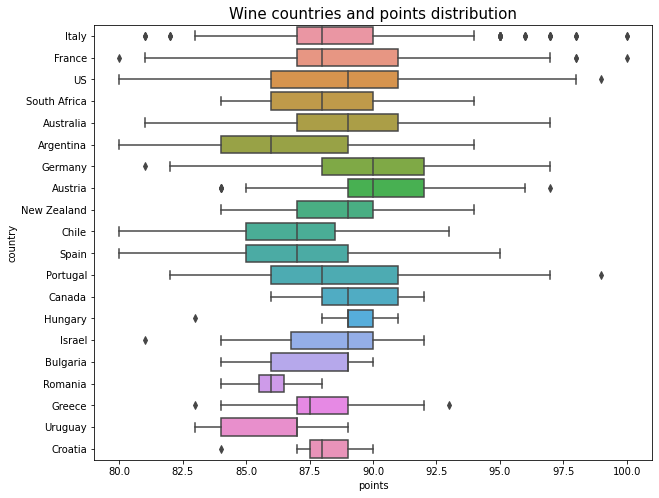

In [10]:
plt.figure(figsize=(10,8))
pop_countries= data.groupby('country').size().nlargest(20).index
countries_plt= sns.boxplot( y='country', x='points', orient= 'horizontal', 
                  data= data[ data.country.isin(pop_countries)])
countries_plt.set_title('Wine countries and points distribution',fontsize=15)
plt.show()

In [11]:
data.groupby('country').size().nlargest()

country
US          4130
France      1724
Italy       1470
Spain        519
Portugal     423
dtype: int64

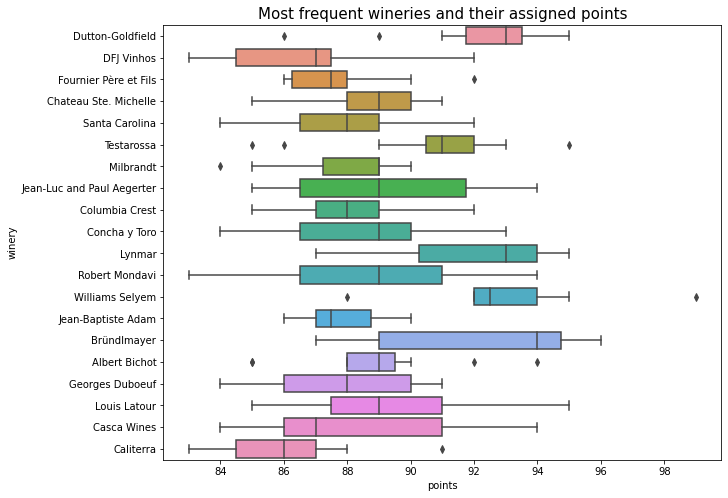

In [12]:
plt.figure(figsize=(10,8))
pop_wineries= data.groupby('winery').size().nlargest(20).index
wineries_plt= sns.boxplot( y='winery', x='points', orient= 'horizontal',
            data= data[ data.winery.isin(pop_wineries)])
wineries_plt.set_title('Most frequent wineries and their assigned points',
                       fontsize=15)
plt.show()

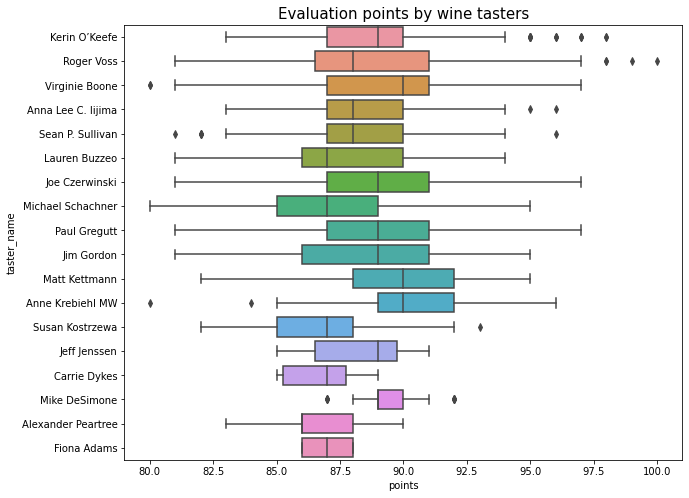

In [13]:
plt.figure(figsize=(10,8))
tasters_plt= sns.boxplot( y='taster_name', x='points', 
                         orient= 'horizontal',data= data)
tasters_plt.set_title('Evaluation points by wine tasters',fontsize=15)
plt.show()

In [14]:
pd.crosstab( data.taster_name, data.country)

country,Argentina,Armenia,Australia,Austria,Brazil,Bulgaria,Canada,Chile,Croatia,Cyprus,...,Portugal,Romania,Serbia,Slovenia,South Africa,Spain,Switzerland,Turkey,US,Uruguay
taster_name,,,,,,,,,,,,,,,,,,,,,
Alexander Peartree,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,26,0
Anna Lee C. Iijima,0,0,0,0,0,2,0,0,4,0,...,0,6,0,1,0,0,0,1,187,0
Anne Krebiehl MW,0,0,0,181,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Carrie Dykes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,0
Fiona Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0
Jeff Jenssen,0,0,0,0,0,11,0,0,3,0,...,0,4,2,5,0,0,1,0,0,0
Jim Gordon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,324,0
Joe Czerwinski,0,0,141,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,9,0
Kerin O’Keefe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


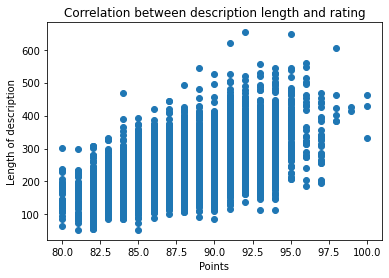

In [15]:
plt.scatter( data.points, data.description.str.len())
plt.xlabel( 'Points')
plt.ylabel( 'Length of description')
plt.title('Correlation between description length and rating')
plt.show()

The TF-IDF features are too variegated for the descriptions in the dataset. This was seen by computing the cosine similarity of the TF-IDF of description after tokenization. The yellow diagonal on the figure below is expected since cosine similarity of a text with itself is 1. Nonetheless, the diagonal line is too sharp, on the other hand, a blurred or a thick line would have signified that the TF-IDF features are similar for similar ratings.

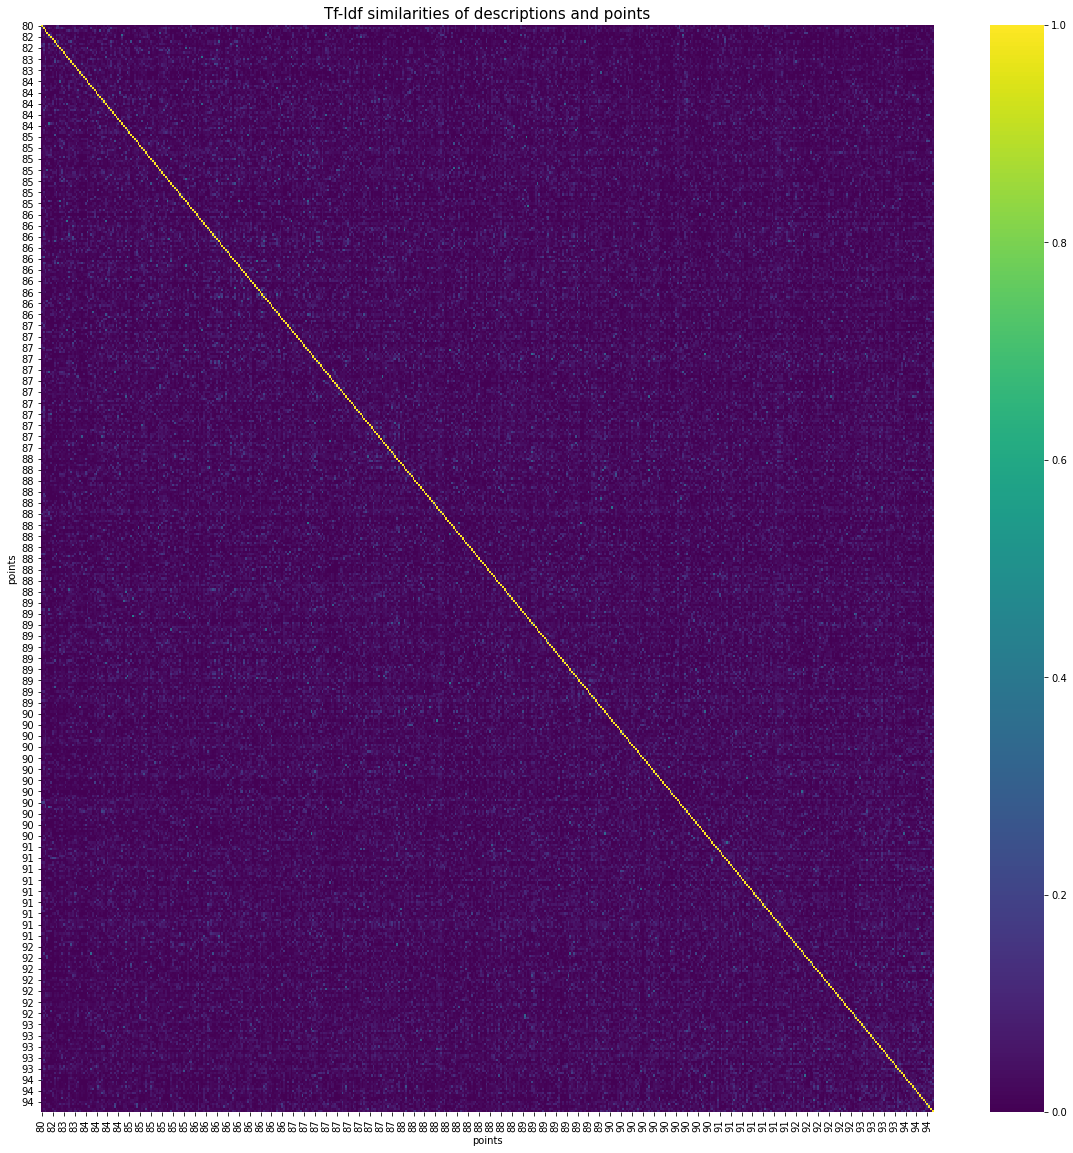

In [16]:
plt.figure(figsize=(20,20))
cos_sim= similarities( data)
sim_plt= sns.heatmap( cos_sim, cmap= 'viridis')
sim_plt.set_title('Tf-Idf similarities of descriptions and points',
               fontsize=15)
plt.show()

___

### Feature engineering, feature selection, and modeling

---

In [17]:
y= data.points
train_x, test_x, train_y, test_y = train_test_split( data.copy(), y, 
                                    test_size = 0.1)


• The age feature was computed by first extracting the year out of the title feature and then calculating its relative timeline compared with the latest year in the dataset. Such treatment is intuitive in a sense that the relative age of the wine might be relevant given the chemical reactions that take time to change the taste of wine.
• The description length, sentiment, positive words, and negative words were extracted from the description feature. The description length is the character count of the description including punctuation. The sentiment is the compound score assigned to the description by NLTK library’s pretrained valence aware dictionary and sentiment reasoner (VADER). Similarly, the positive and negative words are counts of words in description that are in the top and bottom vocabularies respectively. The top vocabulary consists of the highest sentiment words in the description of top 3000 wine ratings. Conversely, the bottom vocabulary is derived from the bottom 3000 wines.
• The _price is simply the logarithmic value of the price. This was implemented to reduce the impact of low frequency ratings.
• The geography is a value representative of the features that deal with location of the wine produced, namely; country, province, region_1, and region_2. The geography is a mean encoded value on descending granularity of location. If the region_2 of the wine is available the mean of the points assigned to this region is assigned to the geography feature, and upon unavailability the region_1 and so on.

In [18]:
train_x= feature_engineer( train_x.copy(), train_x)
test_x.drop( 'points', axis= 1, inplace= True)
test_x= feature_engineer( test_x, train_x)

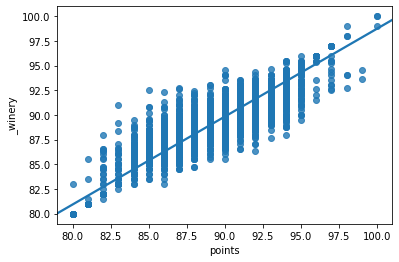

In [19]:
sns.regplot( train_x.points, train_x._winery)
plt.show()

In [20]:
train_x.describe()

,points,price,_winery,desc_len,_geography,age,sentiment,pos_words,neg_words,_price
count,8947.000000,8947.000000,8947.000000,8947.000000,8947.000000,8947.000000,8947.000000,8947.000000,8947.000000,8947.000000
mean,88.457360,35.880056,88.457360,243.862077,88.453184,6.308148,0.516088,1.846988,0.278753,3.327570
std,3.035274,39.890457,2.865136,66.900236,1.582111,3.514866,0.371149,1.454717,0.555523,0.652352
min,80.000000,5.000000,80.000000,53.000000,80.000000,0.000000,-0.840200,0.000000,0.000000,1.609438
25%,86.000000,17.000000,86.500000,198.000000,87.517857,4.000000,0.296000,1.000000,0.000000,2.833213
50%,88.000000,26.000000,88.333333,238.000000,88.714663,6.000000,0.636900,2.000000,0.000000,3.258097
75%,91.000000,42.000000,90.500000,284.000000,89.375000,8.000000,0.821150,3.000000,0.000000,3.737670
max,100.000000,1000.000000,100.000000,653.000000,100.000000,33.000000,0.988700,11.000000,4.000000,6.907755


In [21]:
train_x.corr()

,points,price,_winery,desc_len,_geography,age,sentiment,pos_words,neg_words,_price
points,1.000000,0.430719,0.943947,0.555734,0.522184,-0.048867,0.322201,0.276935,-0.105649,0.591215
price,0.430719,1.000000,0.417348,0.246321,0.367016,0.095607,0.076739,0.083285,-0.000353,0.772504
_winery,0.943947,0.417348,1.000000,0.519942,0.529823,-0.043254,0.301430,0.249757,-0.105921,0.583128
desc_len,0.555734,0.246321,0.519942,1.000000,0.183794,0.072919,0.233881,0.293321,0.082584,0.344678
_geography,0.522184,0.367016,0.529823,0.183794,1.000000,0.054059,0.125948,0.098779,-0.052624,0.533850
age,-0.048867,0.095607,-0.043254,0.072919,0.054059,1.000000,0.096735,0.112366,0.018347,0.106854
sentiment,0.322201,0.076739,0.301430,0.233881,0.125948,0.096735,1.000000,0.755041,-0.336956,0.096750
pos_words,0.276935,0.083285,0.249757,0.293321,0.098779,0.112366,0.755041,1.000000,-0.070874,0.081331
neg_words,-0.105649,-0.000353,-0.105921,0.082584,-0.052624,0.018347,-0.336956,-0.070874,1.000000,-0.013851
_price,0.591215,0.772504,0.583128,0.344678,0.533850,0.106854,0.096750,0.081331,-0.013851,1.000000


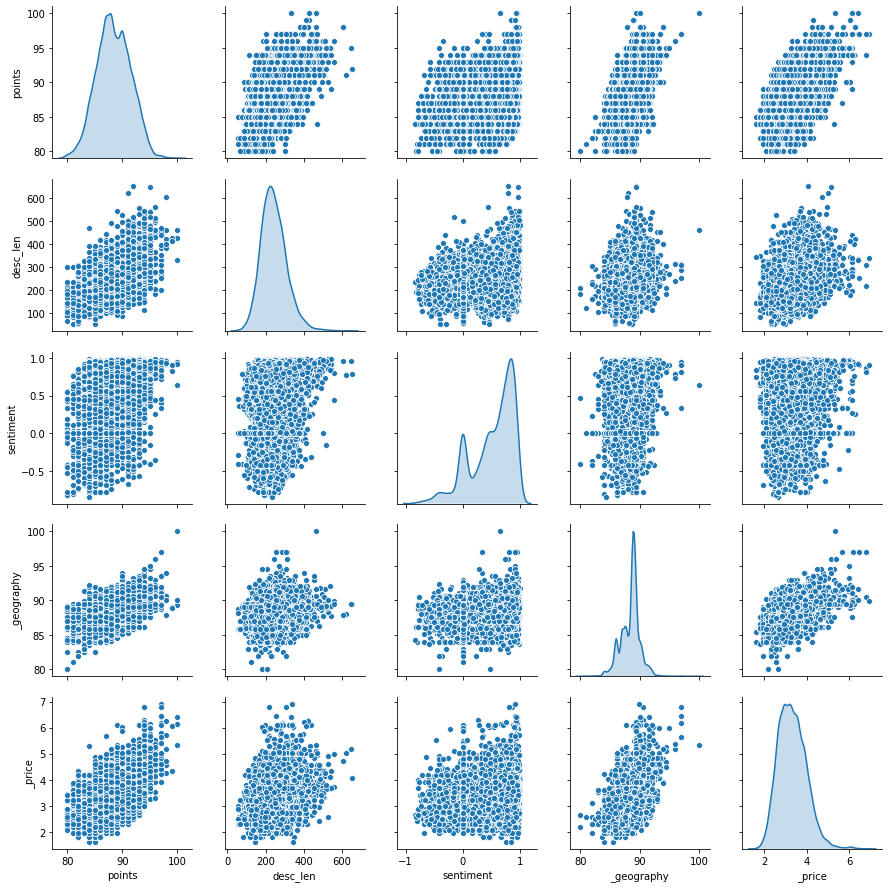

In [22]:
plot_features= ['points','desc_len', 'sentiment', '_geography', '_price']
sns.pairplot( train_x[ plot_features], diag_kind='kde')
plt.show()

>Baseline model

In [23]:
err_baseline= np.sqrt( mean_squared_error( test_y, 
                                           len(test_y)*[train_y.mean()]))
err_baseline

3.0292634722544696

In [24]:
features= ['age', 'desc_len', 'sentiment','pos_words', 'neg_words', 
            '_geography', '_price']

In [25]:
svm= SVR()
svm.fit( train_x[features], train_y.values)
np.sqrt( mean_squared_error( test_y, svm.predict( test_x[features])))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


2.404757902124319

In [26]:
train_x[features].isnull().sum(0)

age           0
desc_len      0
sentiment     0
pos_words     0
neg_words     0
_geography    0
_price        0
dtype: int64

In [27]:
rf= RandomForestRegressor()
rf.fit( train_x[features], train_y.values)
np.sqrt( mean_squared_error( test_y, rf.predict( test_x[features])))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


2.113101034001805

In [28]:
p= {'learning_rate' :0.1,'max_depth':5,'min_child_weight':1}
m= xgb.train(p, xgb.DMatrix( train_x[features], train_y), num_boost_round= 50)
ps= m.predict( xgb.DMatrix( test_x[features]))
np.sqrt( mean_squared_error( test_y, ps))

2.030305926975804

>Hyperparameter tuning of an XGBoost model using Bayesian optimization

In [29]:
def objective( params, n_folds= 10):
    
    num_boost_round= int( params.pop( 'num_boost_round'))
    results= xgb.cv( dtrain= dmatrix, params= params, nfold= n_folds,
                   num_boost_round= num_boost_round)
    
    return { 'loss': results[ 'test-rmse-mean'].tail(1), 
            'status': STATUS_OK }

params_space= {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'num_boost_round': hp.quniform('num_boost_round', 10, 300, 10),
    'learning_rate': hp.loguniform( 'learning_rate', np.log( 0.01), 
                                   np.log(0.3)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 4, 1),
    'max_depth': hp.choice( 'max_depth', np.arange( 2, 6, dtype= int)),
    'gamma' : hp.uniform( 'gamma', 0.1, 0.4),
    'subsample': hp.uniform( 'subsample', 0.8, 1),
    'colsample_bytree': hp.uniform( 'colsample_bytree', 0.4, 0.8),
    'reg_alpha': hp.uniform( 'reg_alpha', 0.3, 9.0),
    'reg_lambda': hp.uniform( 'reg_lambda', 0.3, 9.0),
}

In [30]:
trials= Trials()
dmatrix= xgb.DMatrix( train_x[features], train_y)

tuning= fmin( objective, params_space, algo= tpe.suggest, max_evals= 50, 
             trials= trials)

100%|██████████| 50/50 [03:34<00:00,  4.28s/trial, best loss: 1.8403473]         


In [31]:
params= { param: val for param, val in trials.argmin.items()}
params['eval_metric']= 'rmse'
params['objective']= 'reg:squarederror'
n_estimators= int( params.pop( 'num_boost_round'))
xgb_model= xgb.train( params, dmatrix, num_boost_round= n_estimators)

In [32]:
preds= xgb_model.predict( xgb.DMatrix( test_x[features]))
err= np.sqrt( mean_squared_error( test_y, preds))
err

1.9722061135647242

>The mean squared error of the model on test dataset is approximately 1.99 and the best hyperparameters for fiting the dataset using cross validation is shown below.

In [33]:
trials.argmin

{'colsample_bytree': 0.49440404023393886,
 'gamma': 0.3330965422732798,
 'learning_rate': 0.07514186464929677,
 'max_depth': 3,
 'min_child_weight': 3.0,
 'num_boost_round': 280.0,
 'reg_alpha': 3.6852689305048636,
 'reg_lambda': 8.287697739017165,
 'subsample': 0.8853235909781079}

>Visualizations of the model and predictions

The different features were proportionally considered in making predictions as could be seen from the feature importance graph. The least important features were the positive and negative words. This aligns with the earlier finding of the dissimilarity of TF-IDF vectors of similarly rated wines.


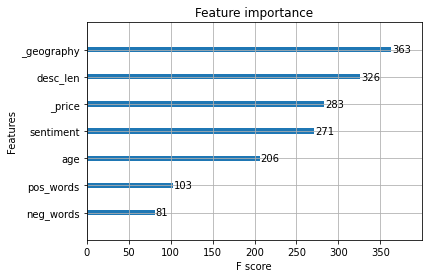

In [34]:
xgb.plot_importance( xgb_model)
plt.show()

In [35]:
idx= np.argsort( test_y)

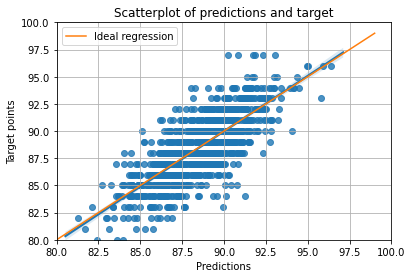

In [36]:
sns.regplot( preds[ idx], np.sort( test_y))
plt.plot( range( 80, 100), range( 80,100), label= 'Ideal regression')
plt.ylabel( 'Target points')
plt.xlabel( 'Predictions')
plt.ylim( 80, 100)
plt.xlim( 80, 100)
plt.title( 'Scatterplot of predictions and target')
plt.legend()
plt.grid()

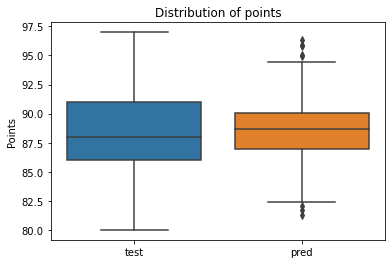

In [37]:
sns.boxplot( x=['test', 'pred'], y= [test_y, preds])
plt.ylabel( 'Points')
plt.title( 'Distribution of points')
plt.show()

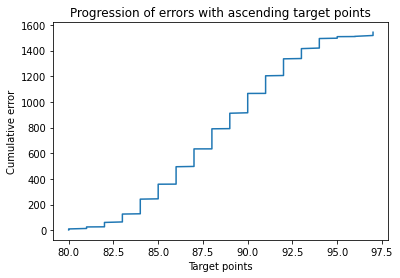

In [38]:
errs_y_asc= abs( np.sort( test_y) - preds[ idx])
plt.plot( np.sort(test_y), errs_y_asc.cumsum(), label= 'rmse= 0.3')
plt.xlabel( 'Target points')
plt.ylabel( 'Cumulative error')
plt.title( 'Progression of errors with ascending target points')
plt.show()

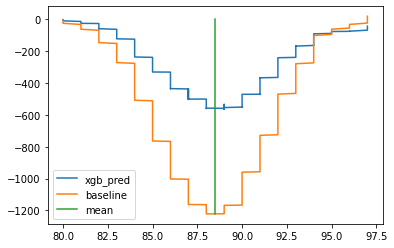

In [39]:
errs_y_asc2= ( np.sort( test_y) - preds[ idx]).cumsum()
errs_baseline= ( np.sort( test_y) - [train_y.mean()]*len(test_y)).cumsum()
plt.plot( np.sort(test_y), errs_y_asc2, label= 'xgb_pred')
plt.plot( np.sort(test_y), errs_baseline, label= 'baseline')
plt.plot( [ test_y.mean(), test_y.mean()], [ 0, errs_baseline.min()], label= 'mean')
plt.legend()
plt.show()

In [40]:
test_pred= pd.DataFrame( {'y': test_y, 'pred': preds})
test_pred['err_abs']= abs( test_pred.y - test_pred.pred)
test_pred['err']= test_pred.y - test_pred.pred

In [41]:
test_pred.describe()

,y,pred,err_abs,err
count,995.000000,995.000000,995.000000,995.000000
mean,88.476382,88.519775,1.550031,-0.043361
std,3.030727,2.261253,1.220040,1.972721
min,80.000000,81.282913,0.003021,-7.263840
25%,86.000000,86.925510,0.572601,-1.321640
50%,88.000000,88.640472,1.286987,-0.016716
75%,91.000000,90.068893,2.231075,1.228104
max,97.000000,96.366089,7.263840,6.734764


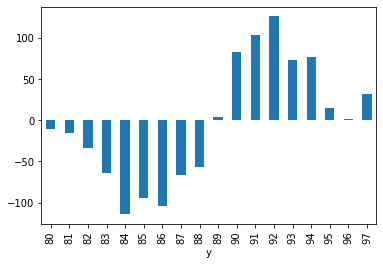

In [42]:
test_pred.groupby('y').err.sum().astype(np.float16).plot( kind= 'bar')
plt.show()

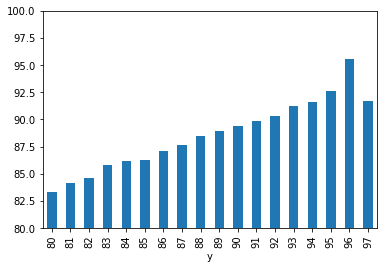

In [43]:
test_pred.groupby('y').pred.mean().plot( kind= 'bar')
plt.ylim( 80, 100)
plt.show()

The errors here are above one standard deviation and could be explained by the importance of the geography feature in decision making of the model. Especially, in the case of the highest rated wine, the generous description, as could be inferred from desc_len, and the high sentiment were disproportionately offset by the geography feature.

In [45]:
errs_main= test_pred.reset_index( drop= True).sort_values( 'err')
pd.concat( [errs_main.reset_index(), test_x.iloc[errs_main.index].reset_index()], axis= 1).drop('index', axis= 1)

,y,pred,err_abs,err,country,description,designation,price,province,region_1,...,variety,winery,_winery,desc_len,_geography,age,sentiment,pos_words,neg_words,_price
0,84,91.263840,7.263840,-7.263840,US,"Heavy, soft and a little sweet, this lacks the...",Reserve L'Argile,65.000000,California,Carneros,...,Pinot Noir,Domaine Chandon,88.457360,267,89.037975,12,0.9301,5,0,4.174387
1,83,89.928795,6.928795,-6.928795,US,"Both tart and tannic, it's unusually tight in ...",Fashauer Vineyard,38.000000,California,Anderson Valley,...,Zinfandel,Witching Stick,88.457360,222,91.325000,5,0.4939,1,0,3.637586
2,84,90.097008,6.097008,-6.097008,Germany,The little-known Mosel village of Reil is the ...,Reiler Mullay-Hofberg Molun,30.000000,Mosel,NaN,...,Riesling,Melsheimer,88.457360,300,90.126761,7,0.5994,3,0,3.401197
3,85,90.799332,5.799332,-5.799332,France,Wood aromas are repeated on the palate with a ...,NaN,75.000000,Bordeaux,Pessac-Léognan,...,Bordeaux-style Red Blend,Château la Louvière,88.457360,222,92.000000,4,-0.4019,0,1,4.317488
4,84,89.581154,5.581154,-5.581154,France,"The name, Haut Païs means high country in the ...",NaN,27.251481,Southwest France,Périgord,...,Bordeaux-style Red Blend,Le Haut Païs,88.457360,244,89.010638,3,0.6369,3,0,3.305108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,97,91.726379,5.273621,5.273621,US,Tasted blind in a large group of Napa Valley C...,Reserve,85.000000,California,Atlas Peak,...,Cabernet Sauvignon,Black Coyote,88.457360,426,89.423158,10,-0.4411,3,1,4.442651
991,94,88.265549,5.734451,5.734451,Portugal,"Mouthfilling and round, without any sharp edge...",Vintage,94.000000,Port,NaN,...,Port,Dow's,91.333333,216,89.959184,20,-0.5719,0,1,4.543295
992,94,88.032036,5.967964,5.967964,US,"Dark and smoky, this wine is relatively tannic...",Impulsivo En Chamberlin Vineyard,80.000000,Oregon,Walla Walla Valley (OR),...,Tempranillo,Cayuse,94.000000,208,88.760000,8,0.0000,0,0,4.382027
993,97,90.861351,6.138649,6.138649,Portugal,"Powerful and dense, this wine exudes the darke...",Vintage,95.000000,Port,NaN,...,Port,Niepoort,92.000000,261,89.959184,12,0.6369,2,0,4.553877


>All in all, the trained model does well on predicting the ratings for different wines.